<a href="https://colab.research.google.com/github/vsjamwal/Algo-trading-Strategies-/blob/main/ST_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install quantstats


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.2 MB/s eta 0:00:00


In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantstats as qs

Stock_symbol= input("enter stock symbol: ")
# Download historical price data for Company for the max time
stock_data = yf.download(Stock_symbol, period='max')

# Download historical price data for Nifty 50 for max time
nifty_data = yf.download('^NSEI', period='max')


enter stock symbol: LT.NS
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


##Strategy 1


[*********************100%%**********************]  1 of 1 completed


Streaming output truncated to the last 5000 lines.
<ipython-input-8-3fe3d519454b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'][data['Buy_Signal']] = 1
<ipython-input-8-3fe3d519454b>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'][data['Exit_Take_Profit'] | data['Exit_Stop_Loss']] = 0
<ipython-input-8-3fe3d519454b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'][data['Buy_Signa

Optimal Fast SMA parameter: 10.0
Optimal Slow SMA parameter: 5.0
Optimal ATR multiplier: 0.1
[Performance Metrics]



                           Strategy
-------------------------  ----------
Start Period               2002-07-02
End Period                 2023-11-10
Risk-Free Rate             0.0%
Time in Market             6.0%

Cumulative Return          204.87%
CAGR﹪                     3.67%

Sharpe                     0.31
Prob. Sharpe Ratio         99.66%
Smart Sharpe               0.31
Sortino                    1.25
Smart Sortino              1.25
Sortino/√2                 0.89
Smart Sortino/√2           0.89
Omega                      1.68

Max Drawdown               -26.63%
Longest DD Days            3666
Volatility (ann.)          22.98%
Calmar                     0.14
Skew                       54.32
Kurtosis                   3519.31

Expected Daily %           0.02%
Expected Monthly %         0.43%
Expected Yearly %          5.2%
Kelly Criterion            21.87%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.35%
Expected Shortfall (cVaR)  -2.35%

Max Consecutive Wins   

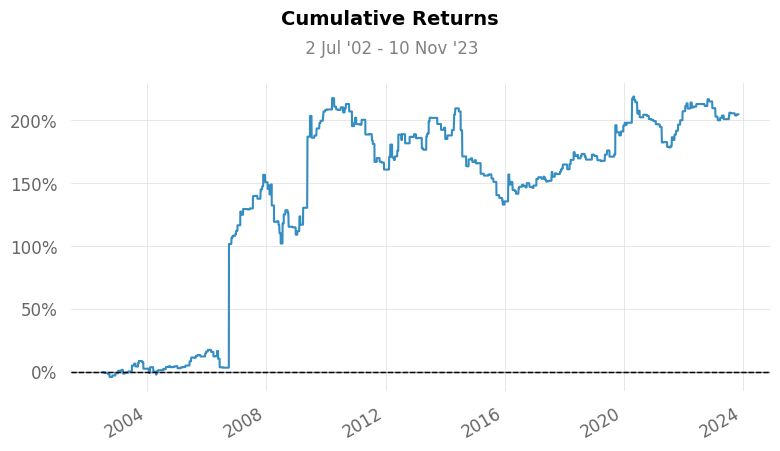

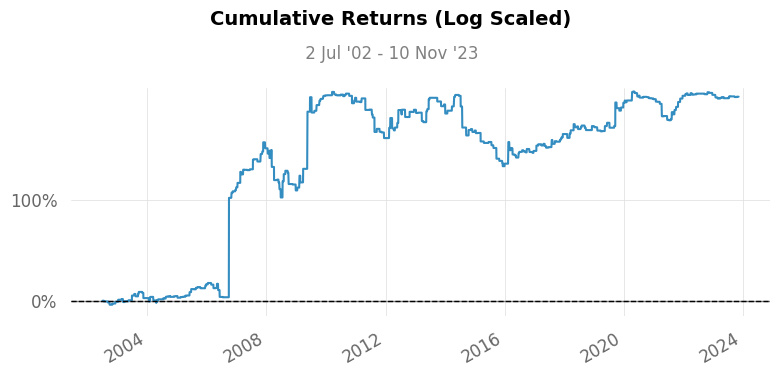

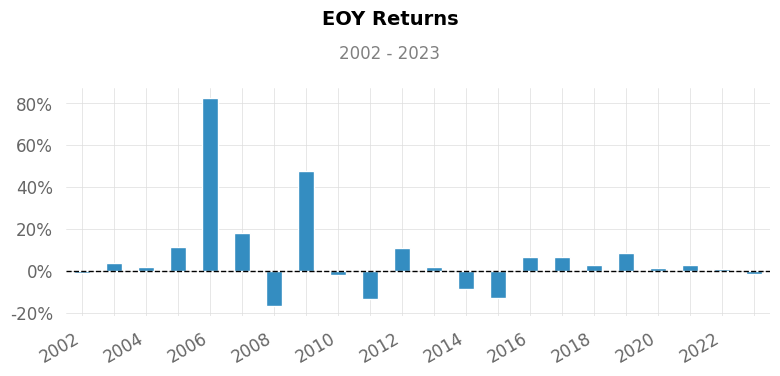

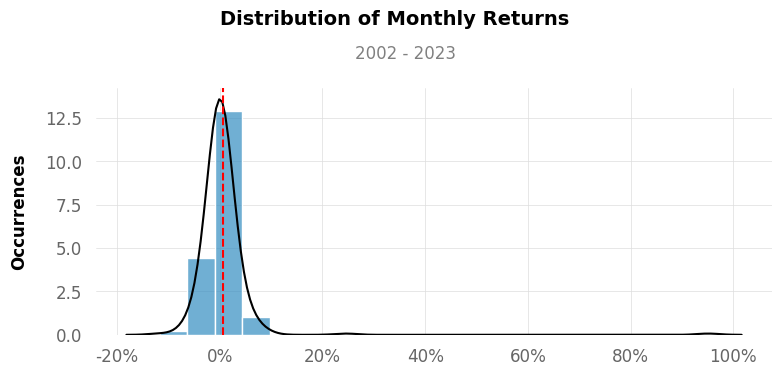

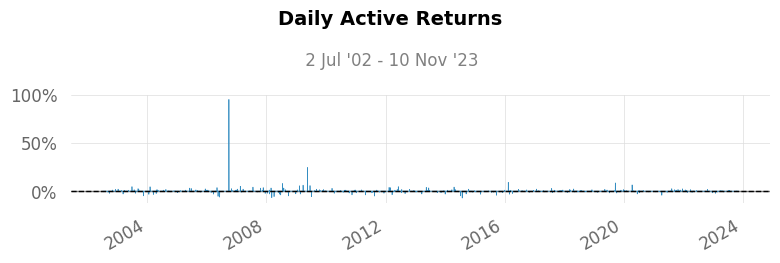

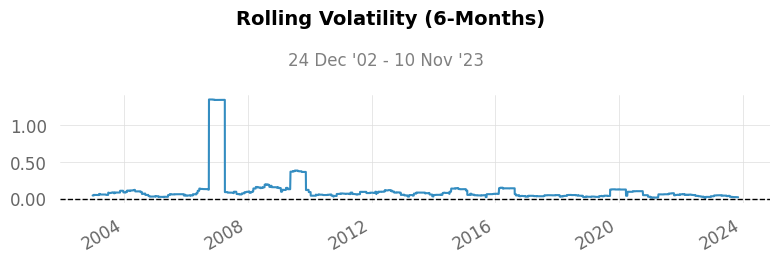

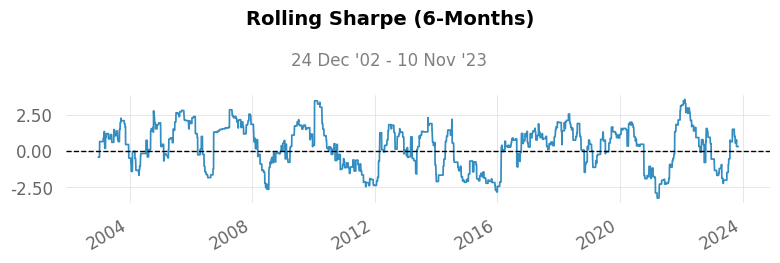

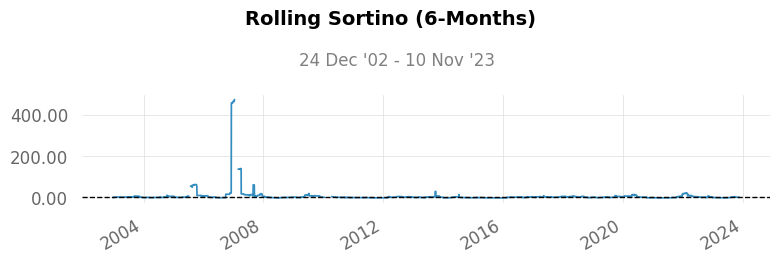

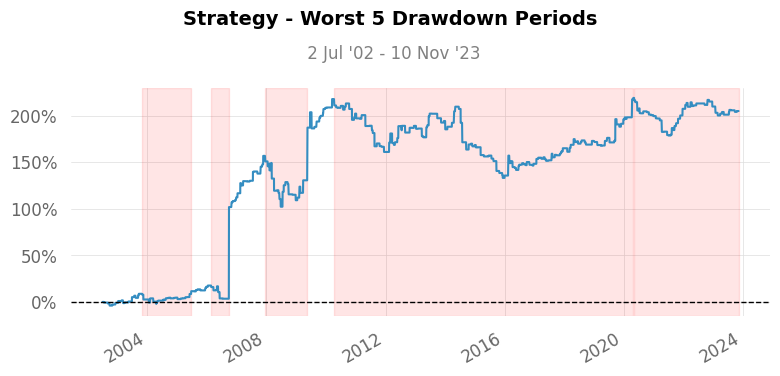

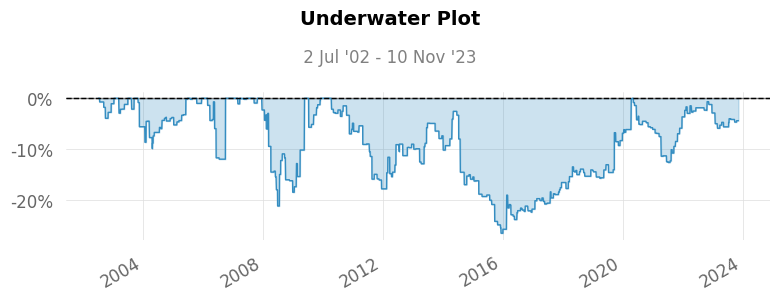

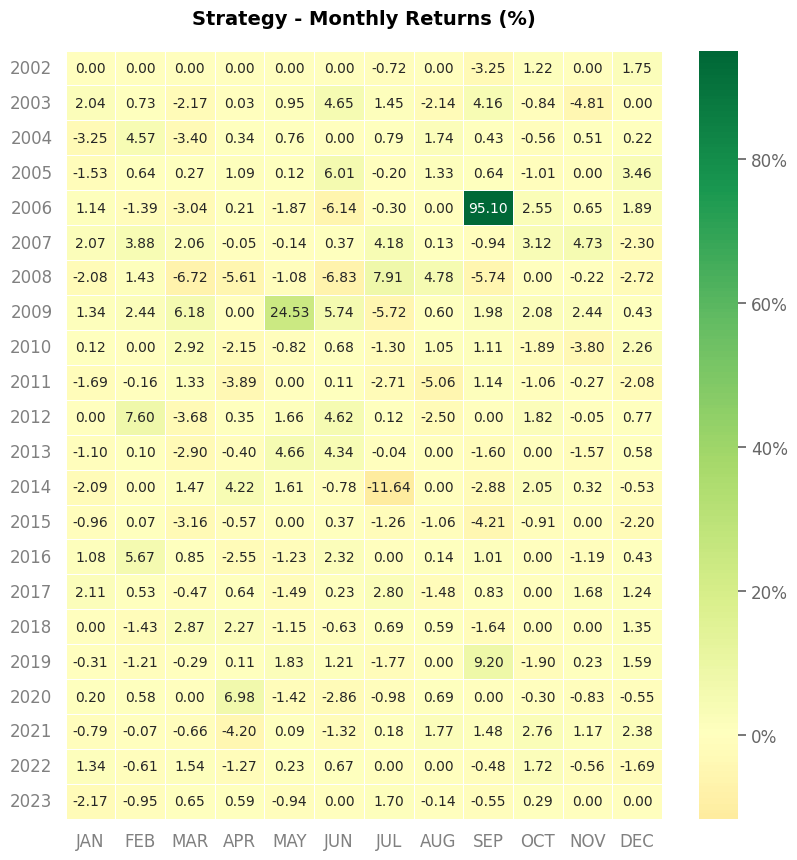

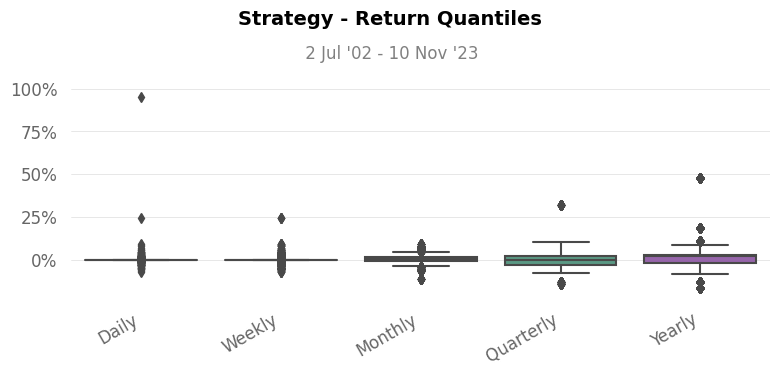

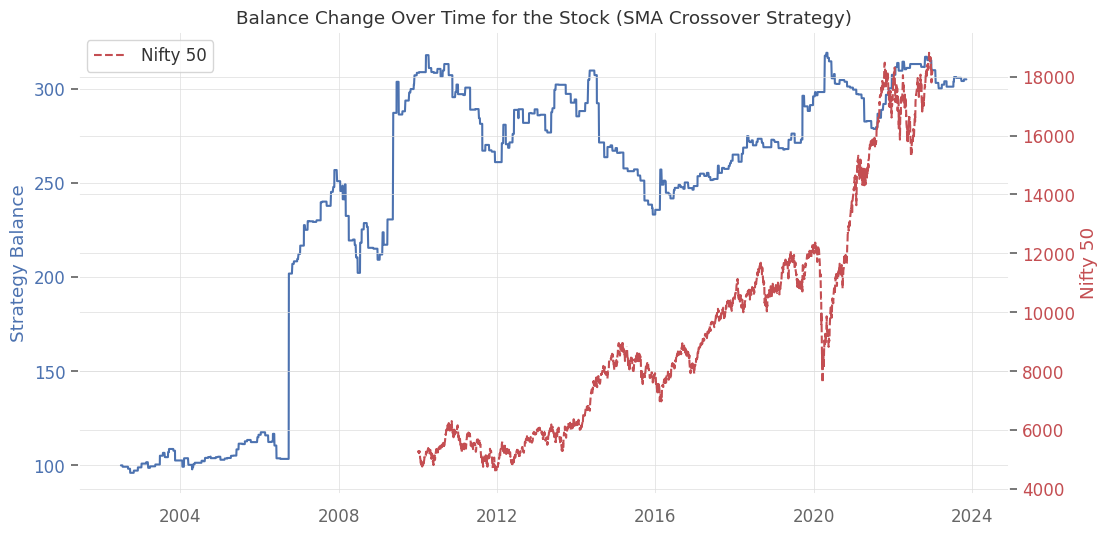

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from tqdm import tqdm
from scipy.optimize import brute
from tqdm import tqdm

# Download Nifty 50 data
nifty_data = yf.download('^NSEI', start='2010-01-01', end='2023-01-01')['Adj Close']

# Function to implement the new SMA crossover strategy
def sma_crossover_strategy(data, fast_sma, slow_sma, atr_multiplier):
    data['Fast_SMA'] = data['Close'].rolling(fast_sma).mean()
    data['Slow_SMA'] = data['Close'].rolling(slow_sma).mean()
    data['ATR'] = data['Close'].diff().abs().rolling(window=14).mean()

    # Generate signals
    data['Buy_Signal'] = (data['Fast_SMA'] > data['Slow_SMA']) & (data['Fast_SMA'].shift(1) <= data['Slow_SMA'].shift(1))
    data['Sell_Signal'] = (data['Fast_SMA'] < data['Slow_SMA']) & (data['Fast_SMA'].shift(1) >= data['Slow_SMA'].shift(1))

    # Initialize positions
    data['Position'] = 0
    data['Position'][data['Buy_Signal']] = 1

    # Entry and exit prices
    data['Entry_Price'] = data['Close'][data['Buy_Signal']]
    data['Take_Profit'] = data['Entry_Price'] + atr_multiplier * data['ATR']
    data['Stop_Loss'] = data['Entry_Price'] - atr_multiplier * data['ATR']

    data['Exit_Take_Profit'] = (data['Close'] >= data['Take_Profit']) & (data['Position'].shift(1) == 1)
    data['Exit_Stop_Loss'] = (data['Close'] <= data['Stop_Loss']) & (data['Position'].shift(1) == 1)

    data['Position'][data['Exit_Take_Profit'] | data['Exit_Stop_Loss']] = 0

    data['Returns'] = data['Close'].pct_change()
    data['Strategy_Return'] = data['Position'].shift(1) * data['Returns']

    return data

# Function to calculate cumulative return
def calculate_cumulative_return(data, balance=100):
    data['Balance'] = balance * (1 + data['Strategy_Return']).cumprod()
    return data

# Optimization function
def objective(params):
    fast_sma, slow_sma, atr_multiplier = params
    stock_copy = stock_data.copy()
    sma_crossover_strategy(stock_copy, int(fast_sma), int(slow_sma), atr_multiplier)
    cumulative_return = calculate_cumulative_return(stock_copy)
    final_balance = cumulative_return['Balance'].iloc[-1]
    return -final_balance  # Negative because we want to maximize the final balance

# Define parameter ranges for optimization
param_ranges = (slice(5, 200, 5), slice(5, 200, 5), slice(0.1, 3.0, 0.1))

# Run optimization
result = brute(objective, param_ranges, finish=None)

# Extract optimized parameters
best_fast_sma, best_slow_sma, best_atr_multiplier = result

print("Optimal Fast SMA parameter:", best_fast_sma)
print("Optimal Slow SMA parameter:", best_slow_sma)
print("Optimal ATR multiplier:", best_atr_multiplier)

# Apply the optimized parameters to the strategy
stock_data_optimized = stock_data.copy()
sma_crossover_strategy(stock_data_optimized, int(best_fast_sma), int(best_slow_sma), best_atr_multiplier)
calculate_cumulative_return(stock_data_optimized)

# Analyze and compare the strategy performance against Nifty 50
aligned_nifty_data = nifty_data.reindex(stock_data_optimized.index)
strategy_returns = stock_data_optimized['Strategy_Return'].dropna()

# Use QuantStats to analyze and print performance metrics
qs.reports.full(strategy_returns, benchmark_rets=aligned_nifty_data, title='SMA Crossover Strategy Performance vs. Nifty 50')

# Plot the balance change over time
plt.figure(figsize=(12, 6))

# Plot the strategy balance on the left y-axis
plt.plot(stock_data_optimized.index, stock_data_optimized['Balance'], color='b', label='Strategy')
plt.ylabel('Strategy Balance', color='b')
plt.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for the benchmark
ax2 = plt.gca().twinx()
ax2.plot(aligned_nifty_data, label='Nifty 50', linestyle='--', color='r')
ax2.set_ylabel('Nifty 50', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Balance Change Over Time for the Stock (SMA Crossover Strategy)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()

plt.show()
